# Up/Down decon with stochastic gradient algorithms for multiple virtual sources with reciprocity preconditioner - Salt Model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import xarray as xr
import torch
import torchvision
import torch.nn as nn
import pylops_gpu

from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt,convolve
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from torch.autograd import gradcheck
from pylops_gpu.utils.backend import device
from torch.nn import MSELoss
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset, DataLoader

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.utils.signalprocessing     import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.waveeqprocessing.mdd import MDC, MDD
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from stochmdd import MDDminibatch, MDDpage

## Parameters

In [2]:
inputdir = '/home/ravasim/Documents/Data/DirtySalt_Utrecht/Roperator_data/data/'

jtdata = 2 # shift to apply to the Mck pup

datakind = 'marchenko' # 'marchenko' or 'mdcmodelled'
jt = 0 # shift to apply to R to allow alignment with Rest (obsolete)

niter = 20 # MDD iterations

nr = 151
ivs = 75 # virtual source for analysis and visualization

# 1.
#nepochs = niter
#batch_size = 21

# 2.
#nepochs = niter
#batch_size = 11

# 3.
nepochs = niter
batch_size = 32

# 4.
#nepochs = niter
#batch_size = 64

## Data preparation

In [3]:
ds_mko = xr.open_dataset(os.path.join(inputdir, 'S_mko.nc'))
print("S-MKO REDATUMED WAVEFIELDS: {}".format(ds_mko.keys()))

S-MKO REDATUMED WAVEFIELDS: KeysView(<xarray.Dataset>
Dimensions:  (t: 2001, x_r: 201, x_vs: 151)
Coordinates:
  * t        (t) float64 0.0 0.004 0.008 0.012 0.016 ... 7.988 7.992 7.996 8.0
  * x_r      (x_r) int64 4000 4040 4080 4120 4160 ... 11880 11920 11960 12000
  * x_vs     (x_vs) int64 6000 6020 6040 6060 6080 ... 8920 8940 8960 8980 9000
Data variables:
    g_plus   (t, x_r, x_vs) float64 ...
    g_minus  (t, x_r, x_vs) float64 ...
Attributes:
    dt:          0.004
    dx_r:        40
    dx_vs:       20
    units_t:     s
    units_x_r:   m
    units_x_vs:  m)


In [4]:
# Receivers
r = ds_mko.coords['x_vs'].values
nr = r.size
dr = r[1]-r[0]

# Sources
s = ds_mko.coords['x_r'].values
ns = s.size
ds = s[1]-s[0]

# Time
t = ds_mko.coords['t'].values
nt = t.size
dt = t[1]-t[0]

# Wavelet
wav, _, wav_c = ricker(t[0:51], 20)
wav_c = np.argmax(wav)

In [5]:
# Data (rescale to get values around 1)
pdown = ds_mko['g_plus'].values * 2000
pup = ds_mko['g_minus'].values * 2000

In [6]:
pup.max(), pdown.max()

(0.16284288178508466, 4.025022115941713)

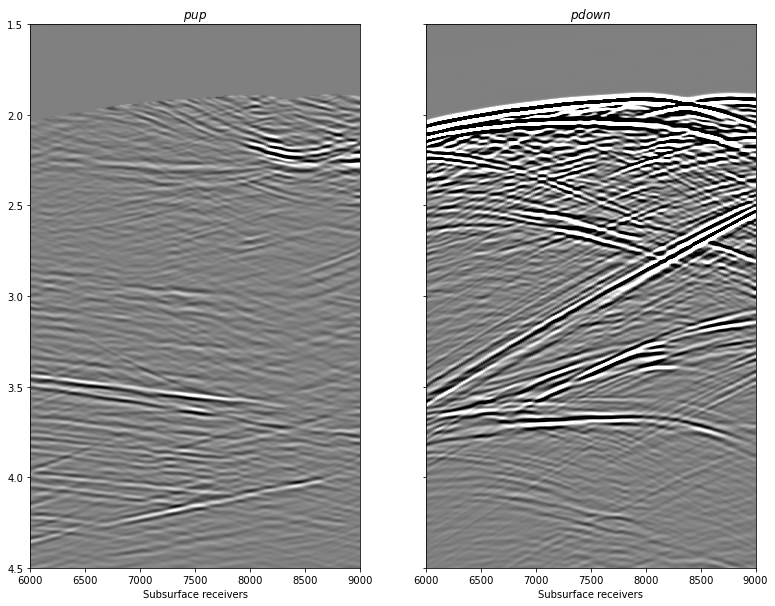

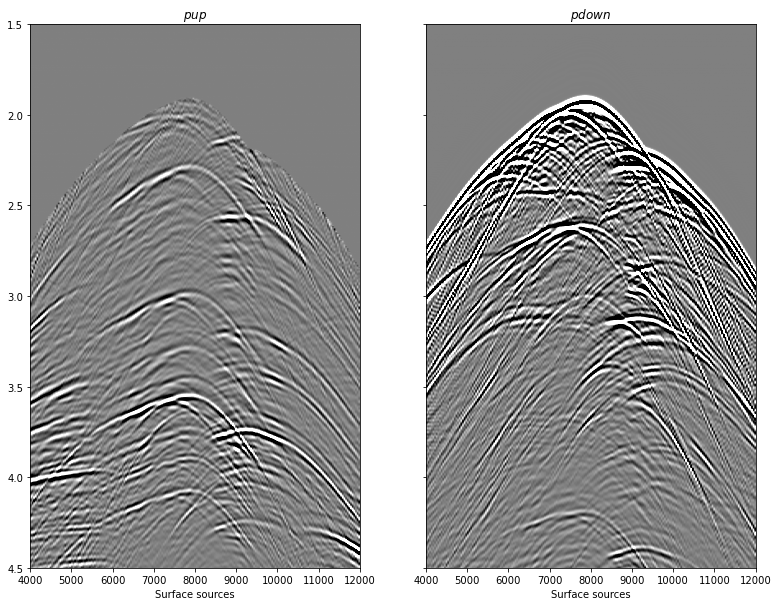

In [7]:
# Pad data with zero at the end (to avoid wrap around)
npad = 5
pdown = np.pad(pdown, ((0, npad), (0, 0), (0, 0)))
ntpad = pdown.shape[0]
tpad = np.arange(ntpad) * dt

pup = np.pad(pup, ((0, npad+jtdata), (0, 0), (0, 0))) 
pup = pup[jtdata:]

clip = 0.005
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(13, 10))
axs[0].imshow(pup[:, ns//2], cmap='gray', vmin=-clip*np.abs(pdown).max(), vmax=clip*np.abs(pdown).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].set_xlabel('Subsurface receivers')
axs[0].axis('tight')
axs[1].imshow(pdown[:, ns//2], cmap='gray', vmin=-clip*np.abs(pdown).max(), vmax=clip*np.abs(pdown).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
axs[1].set_xlabel('Subsurface receivers')
axs[1].axis('tight')
axs[1].set_ylim(4.5, 1.5);

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(13, 10))
axs[0].imshow(pup[:, :, nr//2], cmap='gray', vmin=-clip*np.abs(pdown).max(), vmax=clip*np.abs(pdown).max(),
              extent = (s[0], s[-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].set_xlabel('Surface sources')
axs[0].axis('tight')
axs[1].imshow(pdown[:, :, nr//2], cmap='gray', vmin=-clip*np.abs(pdown).max(), vmax=clip*np.abs(pdown).max(),
              extent = (s[0], s[-1], t[-1], t[0]))
axs[1].set_xlabel('Surface sources')
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')
axs[1].set_ylim(4.5, 1.5);

In [8]:
# FD Local reflection response @ z=4400m, f_max -> 40Hz - axes, attrs included
ds_R = xr.open_dataset(os.path.join(inputdir, 'R_FD_40Hz_z4400.nc'))
print("R FINITE DIFFERENCES 60Hz : {}".format(ds_R.keys()))

Rorig = ds_R['R'].values
Rorig = np.pad(Rorig, ((0, npad), (0, 0), (0, 0)))

tracelim = (1.5, -1.5)

R FINITE DIFFERENCES 60Hz : KeysView(<xarray.Dataset>
Dimensions:  (t: 2001, x_vr: 151, x_vs: 151)
Coordinates:
  * t        (t) float64 0.0 0.004 0.008 0.012 0.016 ... 7.988 7.992 7.996 8.0
  * x_vr     (x_vr) int64 6000 6020 6040 6060 6080 ... 8920 8940 8960 8980 9000
  * x_vs     (x_vs) int64 6000 6020 6040 6060 6080 ... 8920 8940 8960 8980 9000
Data variables:
    R        (t, x_vr, x_vs) float64 ...
Attributes:
    dt:          0.004
    dx_r:        20
    dx_vs:       20
    units_t:     s
    units_x_vr:  m
    units_x_vs:  m)


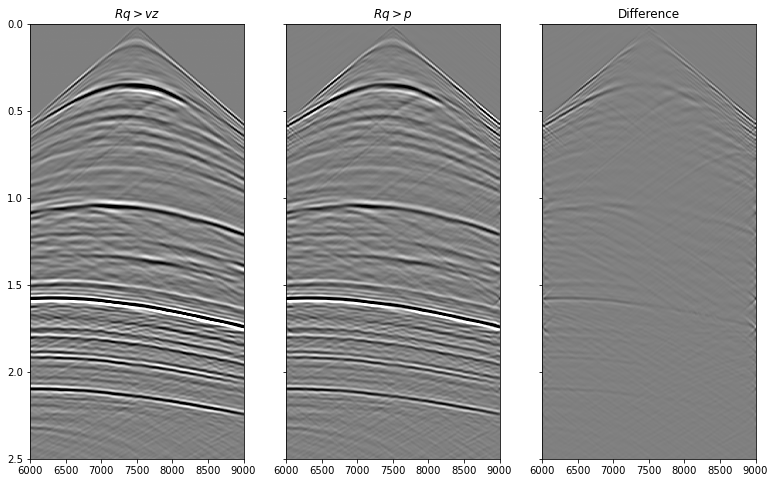

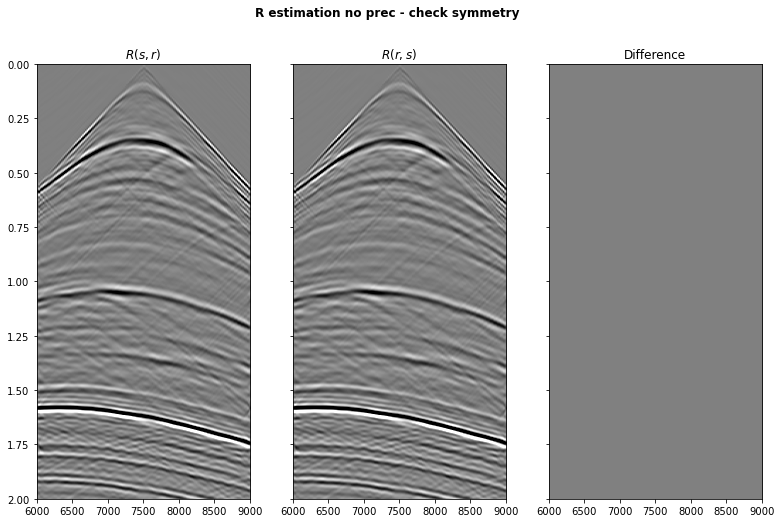

In [9]:
# As R is currently q->vz, transform it into q->q
tracelim = (1e7, -1e7)

rho_sep = 2000
vel_sep = 2766.85
nfftf = ntpad
nfftk = nr
PtoVop = PressureToVelocity(ntpad, nr, dt, dr,
                            rho_sep, vel_sep,
                            nffts=(nfftk, nfftf),
                            critical=100., ntaper=11,
                            topressure=True)           

R = np.hstack([PtoVop * Rorig[:, ir].T.ravel() for ir in range(nr)])
R = np.real(R.reshape(nr, nr, ntpad)).transpose(2, 0, 1)
R = (R + R.transpose(0, 2, 1)) / 2 # enforce reciprocity

clip = 0.1
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13,8))
axs[0].imshow(Rorig[:, nr//2], cmap='gray', vmin=-0.1*np.abs(Rorig).max(), vmax=0.1*np.abs(Rorig).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0].set_title(r'$R q>vz$')
axs[0].axis('tight')
axs[1].imshow(R[:, nr//2], cmap='gray', vmin=-0.1*np.abs(R).max(), vmax=0.1*np.abs(R).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1].set_title(r'$R q>p$')
axs[1].axis('tight')
axs[2].imshow(R[:, nr//2] - Rorig[:, nr//2] * rho_sep * vel_sep, cmap='gray', 
              vmin=-0.1*np.abs(R).max(), vmax=0.1*np.abs(R).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[2].set_title(r'Difference')
axs[2].axis('tight')
axs[2].set_ylim(2.5, 0);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13,8))
fig.suptitle('R estimation no prec - check symmetry', fontweight='bold')
axs[0].imshow(R[:nt, nr//2], cmap='gray', 
              vmin=-clip*np.abs(R).max(), vmax=clip*np.abs(R).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0].set_title(r'$R(s,r)$')
axs[0].axis('tight')
axs[1].imshow(R[:nt, :, nr//2], cmap='gray', 
              vmin=-clip*np.abs(R).max(), vmax=clip*np.abs(R).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1].set_title(r'$R(r,s)$')
axs[1].axis('tight')
axs[2].imshow(R[:nt, nr//2] - R[:nt, :, nr//2], cmap='gray', 
              vmin=-clip*np.abs(R).max(), vmax=clip*np.abs(R).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[2].set_title(r'Difference')
axs[2].axis('tight')
axs[2].set_ylim(2., 0);

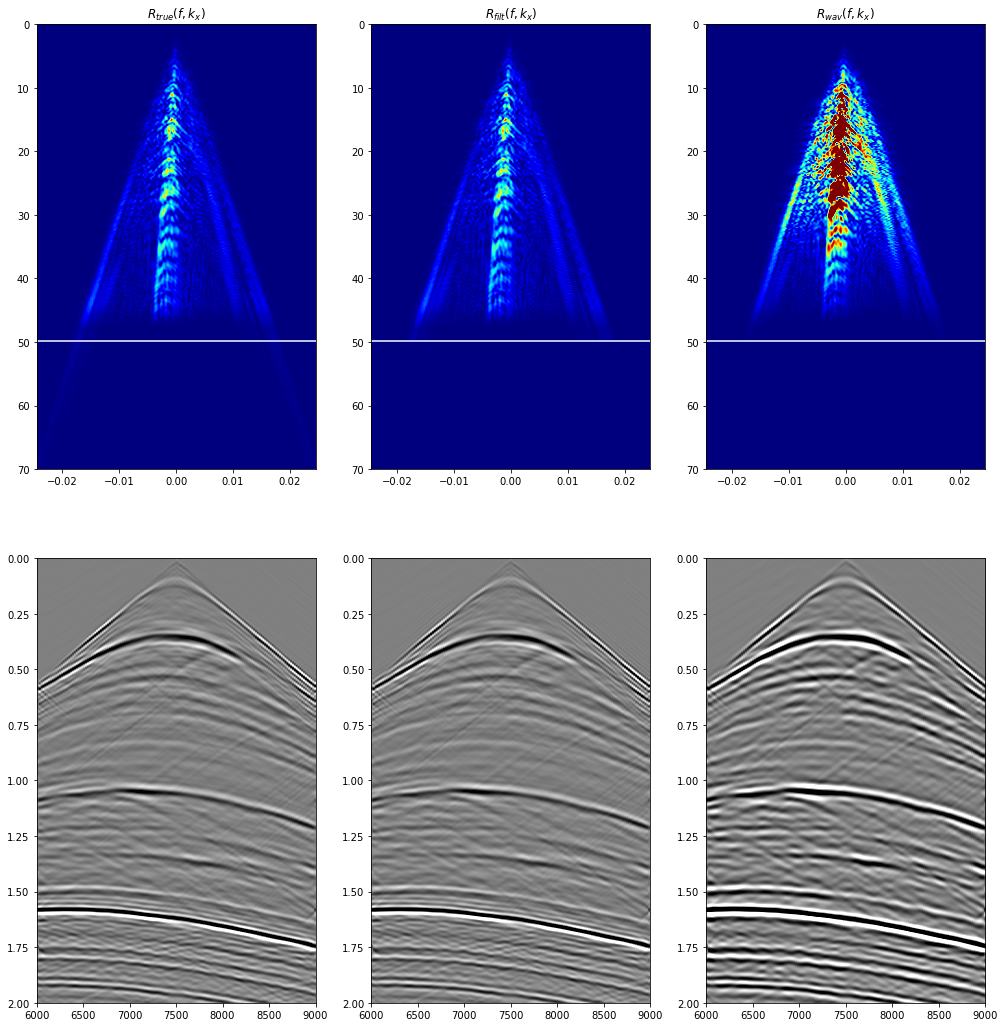

In [10]:
nfmax=400
nfft = ntpad
FFTop = FFT2D(dims=[nr, ntpad], nffts=[nr, nfft], sampling=[dr, dt])
PUP = (FFTop*pup[:, ns//2].T.flatten()).reshape(nr, nfft)
PDOWN = (FFTop*pdown[:, ns//2].T.flatten()).reshape(nr, nfft)

# Filter out high freqs from true response
RTRUE = np.concatenate([(FFTop * R[:, ir].T.ravel()).reshape(1, nr, nfft) for ir in range(nr)], axis=0)
RFILT = RTRUE.copy()
RFILT[:, :, nfmax:-nfmax] = 0
Rfilt = np.concatenate([np.real((FFTop.H * RFILT[ir].ravel()).reshape(1, nr, ntpad)) for ir in range(nr)], axis=0).transpose(2, 0, 1)

# Add wavelet to R
Rfiltwav = np.apply_along_axis(convolve, 0, Rfilt, wav, mode='full')
Rfiltwav = Rfiltwav[wav_c:][:ntpad]
RFILTWAV = np.concatenate([(FFTop * Rfiltwav[:, ir].T.ravel()).reshape(1, nr, nfft) for ir in range(nr)], axis=0)

clip = 0.1
fig, axs = plt.subplots(2, 3, figsize=(17, 18))
axs[0][0].imshow(np.fft.fftshift(np.abs(RTRUE[nr//2, :, :nfft//2-1]),axes=0).T, 
                 cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nr//2-1], FFTop.f1[nr//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[0][0].axhline(FFTop.f2[nfmax], color='w')
axs[0][0].set_title(r'$R_{true}(f, k_x)$')
axs[0][0].axis('tight')
axs[0][0].set_ylim(70, 0);           
axs[0][1].imshow(np.fft.fftshift(np.abs(RFILT[nr//2, :, :nfft//2-1]),axes=0).T, 
                 cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nr//2-1], FFTop.f1[nr//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[0][1].axhline(FFTop.f2[nfmax], color='w')
axs[0][1].set_title(r'$R_{filt}(f, k_x)$')
axs[0][1].axis('tight')
axs[0][1].set_ylim(70, 0)
axs[0][2].imshow(np.fft.fftshift(np.abs(RFILTWAV[nr//2, :, :nfft//2-1]),axes=0).T, 
                 cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nr//2-1], FFTop.f1[nr//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[0][2].axhline(FFTop.f2[nfmax], color='w')
axs[0][2].set_title(r'$R_{wav}(f, k_x)$')
axs[0][2].axis('tight')
axs[0][2].set_ylim(70, 0);           
axs[1][0].imshow(R[:nt, nr//2], cmap='gray', 
                 vmin=-clip*np.abs(R).max(), vmax=clip*np.abs(R).max(),
                 extent = (r[0], r[-1], t[-1], t[0]))
axs[1][0].axis('tight')
axs[1][0].set_ylim(2., 0);
axs[1][1].imshow(Rfilt[:nt, nr//2], cmap='gray', 
                 vmin=-clip*np.abs(R).max(), vmax=clip*np.abs(R).max(),
                 extent = (r[0], r[-1], t[-1], t[0]))
axs[1][1].axis('tight')
axs[1][1].set_ylim(2., 0)
axs[1][2].imshow(Rfiltwav[:nt, nr//2], cmap='gray', 
                 vmin=-clip*np.abs(Rfiltwav).max(), vmax=clip*np.abs(Rfiltwav).max(),
                 extent = (r[0], r[-1], t[-1], t[0]))
axs[1][2].axis('tight')
axs[1][2].set_ylim(2., 0);

## Benchmark MDD

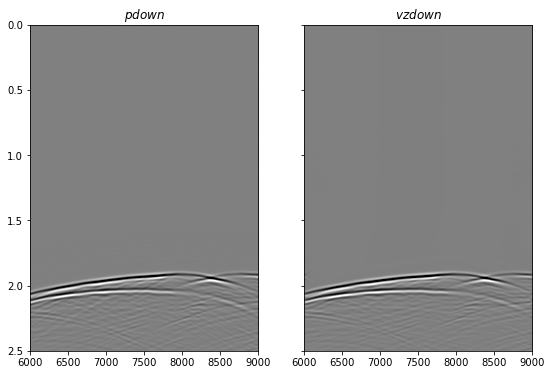

In [11]:
rho_sep = 2000
vel_sep = 2766.85
nfftf = ntpad
nfftk = nr
PtoVop = PressureToVelocity(ntpad, nr, dt, dr,
                            rho_sep, vel_sep,
                            nffts=(nfftk, nfftf),
                            critical=100., ntaper=11,
                            topressure=False)           

vzdown = np.hstack([PtoVop * pdown[:, isrc].T.ravel() for isrc in range(ns)])
vzdown = np.real(vzdown.reshape(ns, nr, ntpad)).transpose(2, 0, 1)
vzdown *= 1e7

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(9,6))
axs[0].imshow(pdown[:, ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0].set_title(r'$pdown$')
axs[0].axis('tight')
axs[1].imshow(vzdown[:, ns//2], cmap='gray', vmin=-0.1*np.abs(vzdown).max(), vmax=0.1*np.abs(vzdown).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1].set_title(r'$vzdown$')
axs[1].axis('tight')
axs[1].set_ylim(2.5, 0);

In [12]:
# all vs
nvsin = 0
nvsend = nr

nvs = nvsend-nvsin
nvs

151

In [13]:
def errnorm(m, mtrue, enorm, nvs, ivs):
    m = m.reshape(mtrue.shape[0], mtrue.shape[1], nvs)[...,ivs]
    #norm.append(np.linalg.norm(m.ravel()/m.ravel().max() - mtrue.ravel()/mtrue.ravel().max()))
    enorm.append(np.linalg.norm(m.ravel()/np.abs(m).ravel().max() - mtrue.ravel()/np.abs(mtrue).ravel().max()))

In [14]:
# Modelling operator
PDOWN = np.fft.rfft(vzdown, ntpad, axis=0)
PDOWN = PDOWN[:nfmax]

MDCop = MDC(PDOWN, nt=ntpad,
            nv=nvs, dt=dt, dr=dr, 
            twosided=False, transpose=False)

# reciprocity prec
Recop =  0.5 * (Identity(ntpad * nr * nr) + \
                Transpose((ntpad, nr, nr), (0, 2, 1)))
MDCop_prec = MDCop * Recop

# Adjoint
Radj = MDCop_prec.H * pup[:, :, nvsin:nvsend].ravel()
Radj = np.real(Radj).reshape(ntpad, nr, nvs)

In [15]:
# Inversion
bench_enorm = []

Rinv, _, _, _, _, bench_resnorm = \
    cgls(MDCop_prec, pup[:, :, nvsin:nvsend].ravel(), niter=niter, 
         x0=np.zeros((ntpad, nr, nvs)).ravel(), damp=1e-9, tol=0., show=1,
         callback=lambda x: errnorm(x, Rfilt[..., ivs], bench_enorm, nvs, ivs),)
Rinv = np.real(Rinv).reshape(ntpad, nr, nvs)
bench_resnorm = bench_resnorm**2 / (ntpad * ns * nvs)

pupinv = MDCop_prec * Rinv.ravel()
pupinv = pupinv.reshape(ntpad, ns, nvs)

CGLS
-----------------------------------------------------------
The Operator Op has 60884106 rows and 45738806 cols
damp = 1.000000e-09	tol = 0.000000e+00	niter = 20
-----------------------------------------------------------
    Itn           x[0]              r1norm          r2norm
     1         7.0207e-07         2.4379e+01      2.4379e+01
     2         2.1310e-06         2.3292e+01      2.3292e+01
     3         4.0945e-06         2.2976e+01      2.2976e+01
     4         6.1924e-06         2.2842e+01      2.2842e+01
     5         7.7995e-06         2.2772e+01      2.2772e+01
     6         8.8081e-06         2.2732e+01      2.2732e+01
     7         9.2449e-06         2.2706e+01      2.2706e+01
     8         9.4079e-06         2.2689e+01      2.2689e+01
     9         9.7601e-06         2.2676e+01      2.2676e+01
    10         1.0519e-05         2.2666e+01      2.2666e+01
    11         1.1651e-05         2.2659e+01      2.2659e+01
    12         1.3074e-05         2.2653e+0

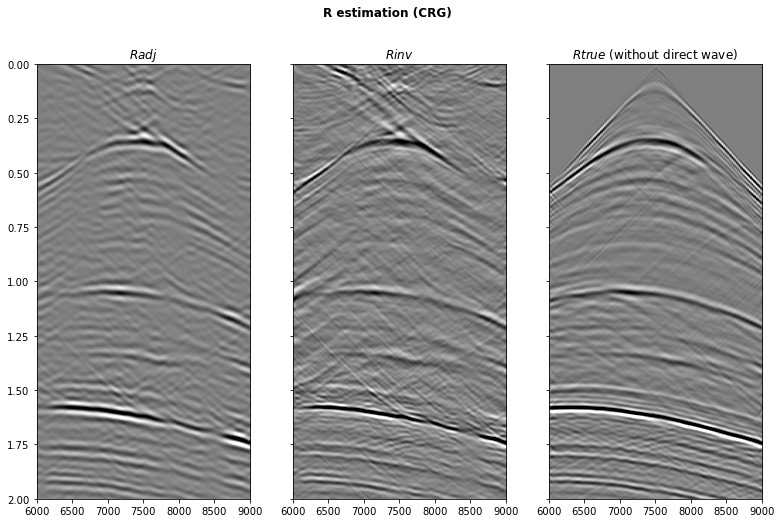

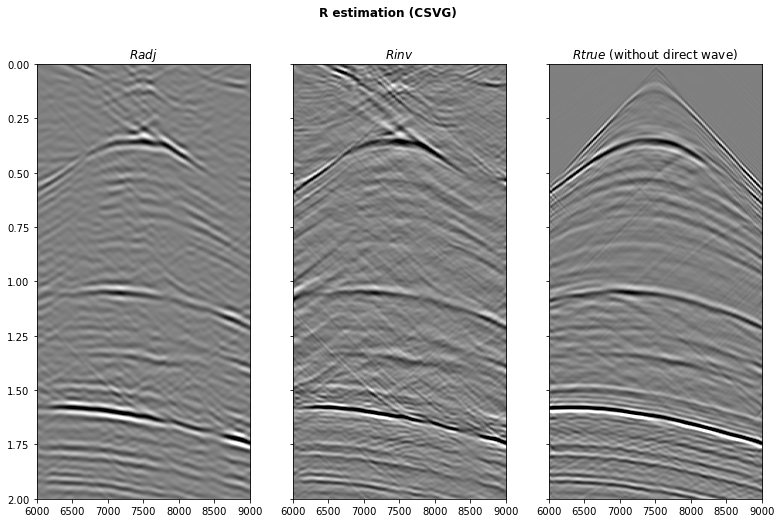

In [16]:
clip = 0.4
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13, 8))
fig.suptitle('R estimation (CRG)', fontweight='bold')
axs[0].imshow(Radj[:nt, nr//2], cmap='gray', 
              vmin=-clip*np.abs(Radj).max(), vmax=clip*np.abs(Radj).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(Rinv[:nt, nr//2], cmap='gray', 
              vmin=-clip*np.abs(Rinv[:,  nr//2]).max(), vmax=clip*np.abs(Rinv[:, nr//2]).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(Rfilt[:nt, :, ivs+nvsin], cmap='gray',
              vmin=-clip*np.abs(Rfilt[:,  nr//2]).max(), vmax=clip*np.abs(Rfilt[:,  nr//2]).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[2].set_title(r'$Rtrue$ (without direct wave)')
axs[2].axis('tight')
axs[2].set_ylim(2., 0);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13, 8))
fig.suptitle('R estimation (CSVG)', fontweight='bold')
axs[0].imshow(Radj[:nt,  :, ivs+nvsin], cmap='gray', 
              vmin=-clip*np.abs(Radj).max(), vmax=clip*np.abs(Radj).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(Rinv[:nt, :, ivs], cmap='gray', 
              vmin=-clip*np.abs(Rinv[:, :, ivs+nvsin]).max(), vmax=clip*np.abs(Rinv[:, :, ivs+nvsin]).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(Rfilt[:nt, :, ivs+nvsin], cmap='gray',
              vmin=-clip*np.abs(Rfilt[:, :, ivs+nvsin]).max(), vmax=clip*np.abs(Rfilt[:, :, ivs+nvsin]).max(),
              extent = (r[0], r[-1], t[-1], t[0]))
axs[2].set_title(r'$Rtrue$ (without direct wave)')
axs[2].axis('tight')
axs[2].set_ylim(2., 0);

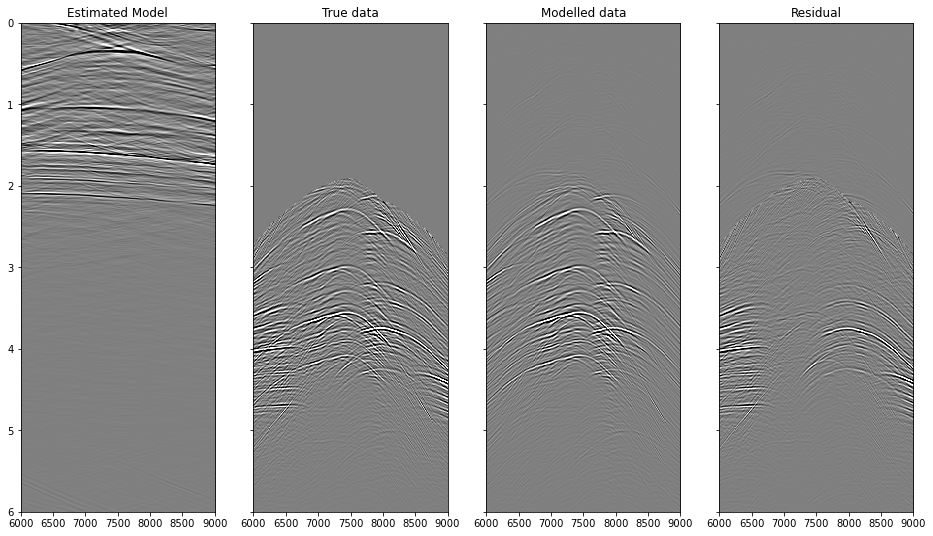

In [17]:
clip = 0.2
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(16, 9))
ax1.imshow(Rinv[:nt, :, ivs], cmap='gray', 
           vmin=-clip*np.abs(Rinv[:nt, :, ivs]).max(), vmax=clip*np.abs(Rinv[:nt, :, ivs]).max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax1.set_title('Estimated Model')
ax1.axis('tight')
ax2.imshow(pup[:nt, :, ivs+nvsin], aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup[:nt, :, ivs].max(), vmax=clip*pup[:nt, :, ivs].max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax2.set_title('True data')
ax3.imshow(pupinv[:nt, :, ivs], aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup[:nt, :, ivs].max(), vmax=clip*pup[:nt, :, ivs].max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax3.set_title('Modelled data')
ax4.imshow((pup[:nt, :, ivs+nvsin]-pupinv[:nt, :, ivs]), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup[:nt, :, ivs+nvsin].max(), vmax=clip*pup[:nt, :, ivs+nvsin].max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax4.set_title('Residual')
ax4.set_ylim(6, 0);

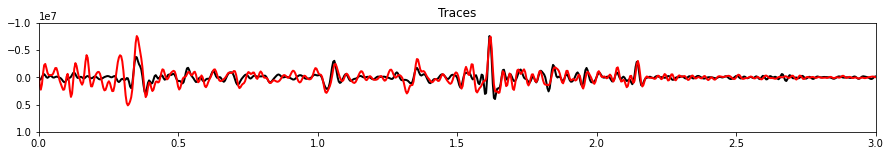

In [18]:
scale = np.abs(Rfilt[:, nr//2, ivs]).max() / np.abs(Rinv[:, nr//2, ivs]).max()

fig, ax = plt.subplots(1, 1, figsize=(15, 2))
ax.plot(t, Rfilt[:nt, nr//2, ivs+nvsin], 'k', lw=2, label='True')
ax.plot(t, Rinv[jt:nt+jt, nr//2, ivs] * scale, 'r', lw=2, label='Inv')
ax.axis('tight')
ax.set_title('Traces')
ax.set_xlim(0, 3)
ax.set_ylim(tracelim[0], tracelim[1]);

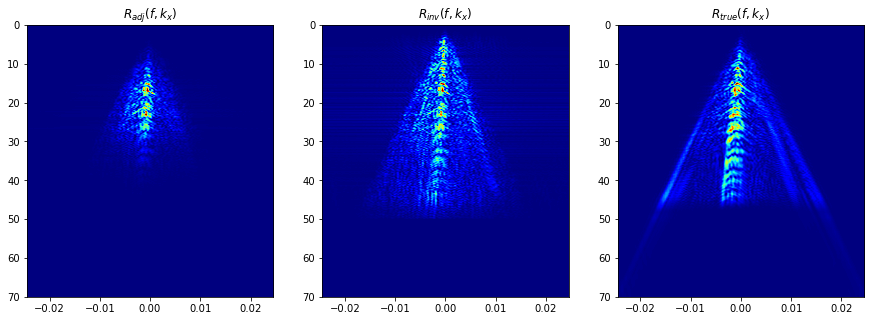

In [19]:
RADJ = (FFTop*Radj[:, :, ivs].T.ravel()).reshape(nr, nfft)
RINV = (FFTop*Rinv[:, :, ivs].T.ravel()).reshape(nr, nfft)
RTRUE = (FFTop*R[..., ivs+nvsin].T.ravel()).reshape(nr, nfft)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(RADJ[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nr//2-1], FFTop.f1[nr//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RADJ).max())
axs[0].axhline(FFTop.f2[2*nfmax], color='w')
axs[0].set_title(r'$R_{adj}(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(70, 0)
im=axs[1].imshow(np.fft.fftshift(np.abs(RINV[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nr//2-1], FFTop.f1[nr//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RINV).max())
axs[1].axhline(FFTop.f2[2*nfmax], color='w')
axs[1].set_title(r'$R_{inv}(f, k_x)$')
axs[1].axis('tight')
axs[1].set_ylim(70, 0)
im=axs[2].imshow(np.fft.fftshift(np.abs(RTRUE[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nr//2-1], FFTop.f1[nr//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[2].axhline(FFTop.f2[2*nfmax], color='w')
axs[2].set_title(r'$R_{true}(f, k_x)$')
axs[2].axis('tight');
axs[2].set_ylim(70, 0);

## Stochastic MDD

In [20]:
eigmax = (MDCop.H @ MDCop).eigs(neigs=1)

PDOWN = dt * dr * np.sqrt(ntpad) * np.fft.rfft(vzdown, ntpad, axis=0)
PDOWN = PDOWN[:nfmax]
eigs = np.linalg.eig(np.matmul(np.conj(PDOWN.transpose(0,2,1)), PDOWN))[0]
eigs = np.fliplr(np.sort(np.abs(eigs), axis=1))

alphamax1 = 2. / eigs.max() 
alphamax = 2. / np.real(eigmax[0])
print(alphamax1, alphamax)

# Identify learning-rate based on steepest descent first step / analytical upper bound.
# To make it equivalent to analytic steepest descent, denominator compensates for 
# different norm used in torch which is normalized by number of elements
lrstmax = alphamax # from steepest descent notebook
lrstmax * ((nt*ns*nvs)/2)

9.893233913303111e-07 9.89323391330313e-07


30.041967727391462

In [21]:
no_of_batches= int(np.ceil(ns/batch_size))
lossdict = {}
lossepochdict = {}
avgdict = {}
enormdict = {}
mdict = {}

In [22]:
PDOWN = np.fft.rfft(vzdown, ntpad, axis=0)
PDOWN = PDOWN[:nfmax]

#R = torch.from_numpy(R)
R = torch.from_numpy(Rfilt)
PDOWN = torch.from_numpy(PDOWN)
pup = torch.from_numpy(pup[:, :, nvsin:nvsend])

### SGD

In [23]:
lr = {}
# 10 vs
lr[32] = 0.2

# all vs
lr[32] = 2.

model, dmod, lossdict['SGD'], avgdict['SGD'], lossepochdict['SGD'], enormdict['SGD'], _ = \
                 MDDminibatch(ntpad, nr, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=R[..., nvsin+ivs], ivstrue=ivs, 
                              seed=0, epochprint=5, reciprocity=True, enormabsscaling=True,
                              **dict(lr=lr[batch_size], weight_decay=0))
mdict["SGD"] = model.detach().numpy()

Initial Gradient norm: 1.295162e-06, scaled by lr: 5.180649e-06
Initial Gradient norm as np.linalg.norm: 5.515564e+03, scaled by nbatches:  3.464464e+04
epoch:   5, loss : 1.0051e-05, loss avg : 9.2965e-06
epoch:  10, loss : 5.2550e-06, loss avg : 8.4756e-06
epoch:  15, loss : 8.0164e-06, loss avg : 8.6654e-06
epoch:  20, loss : 4.3220e-06, loss avg : 8.2416e-06
Final Model norm: 6.596906e-04


In [24]:
# First loss 
np.sum(np.abs(pup.reshape(-1).numpy())**2) / (len(pup.reshape(-1))), lossepochdict['SGD'][0], bench_resnorm[0]

(1.7671999885275946e-05, 1.767199988527586e-05, 1.767199988527585e-05)

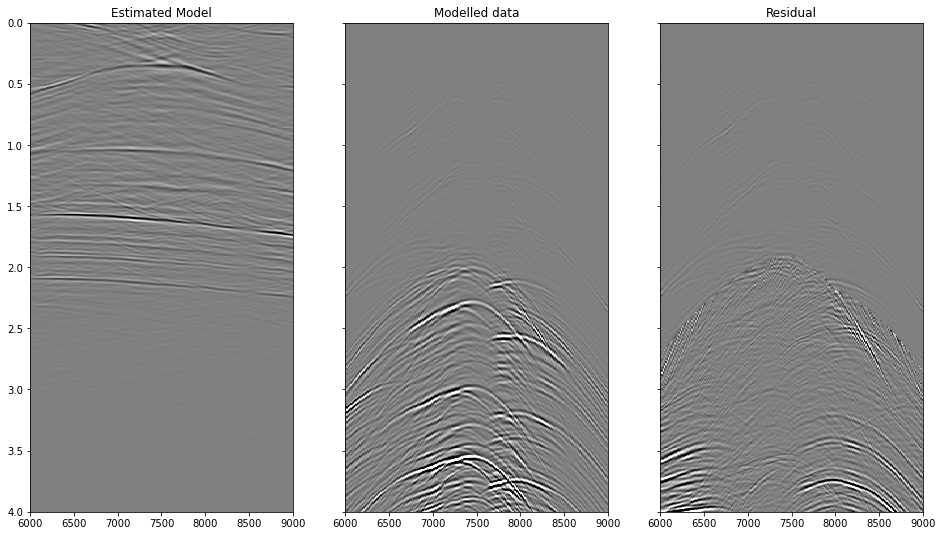

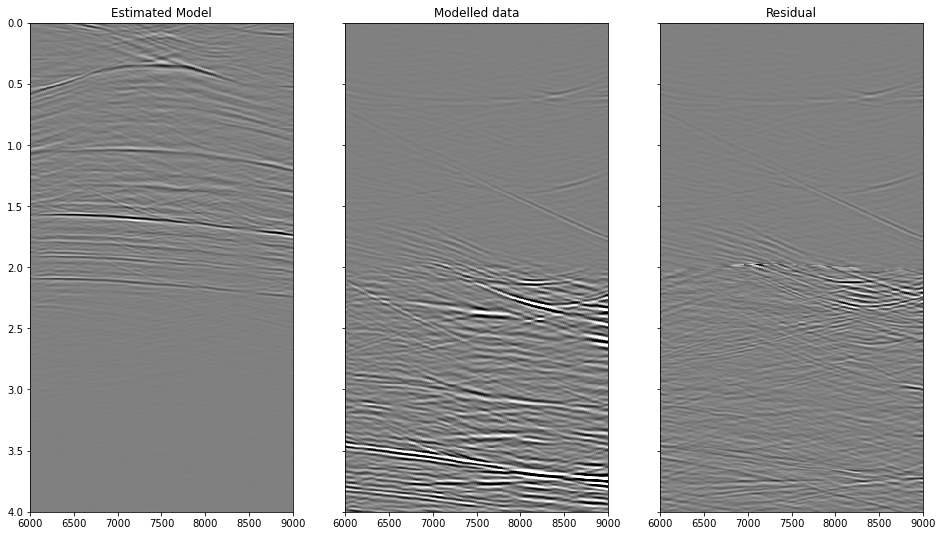

In [25]:
clip = 0.2
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(model[..., ivs].detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-6e-5, vmax=6e-5,
           extent = (r[0], r[-1], t[-1], t[0]))
ax1.set_title('Estimated Model')
ax2.imshow(dmod[..., ivs].detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup[..., ivs].detach().numpy().max(), vmax=clip*pup[..., ivs].detach().numpy().max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax2.set_title('Modelled data')
ax3.imshow((dmod[..., ivs]-pup[..., ivs]).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup[..., ivs].detach().numpy().max(), vmax=clip*pup[..., ivs].detach().numpy().max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax3.set_title('Residual')
ax3.set_ylim(4, 0);

fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(model[:, nr//2].detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-6e-5, vmax=6e-5,
           extent = (r[0], r[-1], t[-1], t[0]))
ax1.set_title('Estimated Model')
ax2.imshow(dmod[:, nr//2].detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup[:, nr//2].detach().numpy().max(), vmax=clip*pup[:, nr//2].detach().numpy().max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax2.set_title('Modelled data')
ax3.imshow((dmod[:, nr//2]-pup[:, nr//2]).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup[:, nr//2].detach().numpy().max(), vmax=clip*pup[:, nr//2].detach().numpy().max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax3.set_title('Residual')
ax3.set_ylim(4, 0);

### SGD with momentum

In [26]:
lr = {}
# 10 vs
lr[32] = 0.2

# all vs
lr[32] = 2.

model, dmod, lossdict['SGDMom'], avgdict['SGDMom'], lossepochdict['SGDMom'], enormdict['SGDMom'], _ = \
                 MDDminibatch(ntpad, nr, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=R[..., nvsin+ivs], ivstrue=ivs, 
                              seed=0, epochprint=5, reciprocity=True, enormabsscaling=True,
                              **dict(lr=lr[batch_size], weight_decay=1e-4, momentum=0.8, nesterov=True))
mdict["SGDMom"] = model.detach().numpy()

Initial Gradient norm: 1.295162e-06, scaled by lr: 5.180649e-06
Initial Gradient norm as np.linalg.norm: 5.515564e+03, scaled by nbatches:  3.464464e+04
epoch:   5, loss : 1.0180e-05, loss avg : 9.2033e-06
epoch:  10, loss : 5.8177e-06, loss avg : 8.7708e-06
epoch:  15, loss : 8.5061e-06, loss avg : 8.9852e-06
epoch:  20, loss : 4.6150e-06, loss avg : 8.5250e-06
Final Model norm: 8.388423e-04


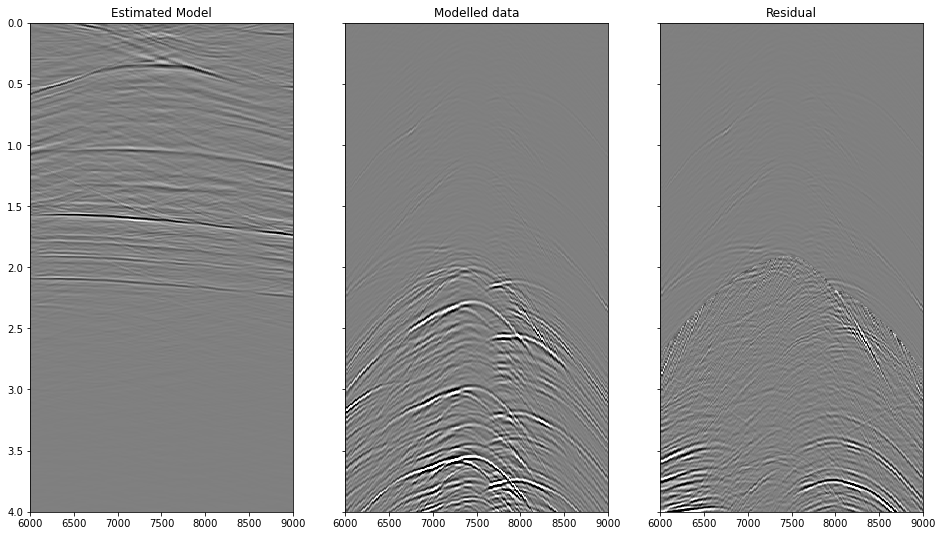

In [27]:
clip = 0.2
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(model[..., ivs].detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-6e-5, vmax=6e-5,
           extent = (r[0], r[-1], t[-1], t[0]))
ax1.set_title('Estimated Model')
ax2.imshow(dmod[..., ivs].detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup[..., ivs].detach().numpy().max(), vmax=clip*pup[..., ivs].detach().numpy().max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax2.set_title('Modelled data')
ax3.imshow((dmod[..., ivs]-pup[..., ivs]).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup[..., ivs].detach().numpy().max(), vmax=clip*pup[..., ivs].detach().numpy().max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax3.set_title('Residual')
ax3.set_ylim(4, 0);

### SGD with momentum and exponential LR

In [28]:
lr = {}
# 10 vs
lr[32] = 0.2

# all vs
lr[32] = 2.

model, dmod, lossdict['SGDMom_LRexp'], avgdict['SGDMom_LRexp'], lossepochdict['SGDMom_LRexp'], enormdict['SGDMom_LRexp'], lr = \
                 MDDminibatch(ntpad, nr, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, 
                              mtrue=R[..., nvsin+ivs], ivstrue=ivs, seed=0,
                              scheduler=torch.optim.lr_scheduler.ExponentialLR, epochprint=5, 
                              reciprocity=True, enormabsscaling=True,
                              kwargs_sched=dict(gamma=0.99, last_epoch=-1, verbose=False),
                              **dict(lr=lr[batch_size], weight_decay=1e-4, momentum=0.8, nesterov=True))
                 
mdict["SGDMom_LRexp"] = model.detach().numpy()

Initial Gradient norm: 1.295162e-06, scaled by lr: 5.180649e-06
Initial Gradient norm as np.linalg.norm: 5.515564e+03, scaled by nbatches:  3.464464e+04
epoch:   5, loss : 9.9923e-06, loss avg : 9.0536e-06
epoch:  10, loss : 5.4269e-06, loss avg : 8.4598e-06
epoch:  15, loss : 8.0480e-06, loss avg : 8.6059e-06
epoch:  20, loss : 4.1476e-06, loss avg : 8.1254e-06
Final Model norm: 7.686477e-04


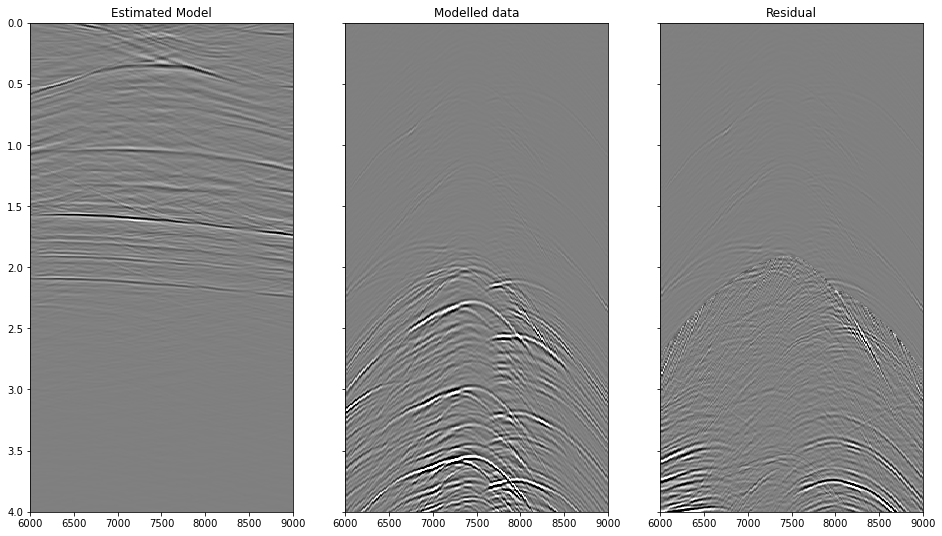

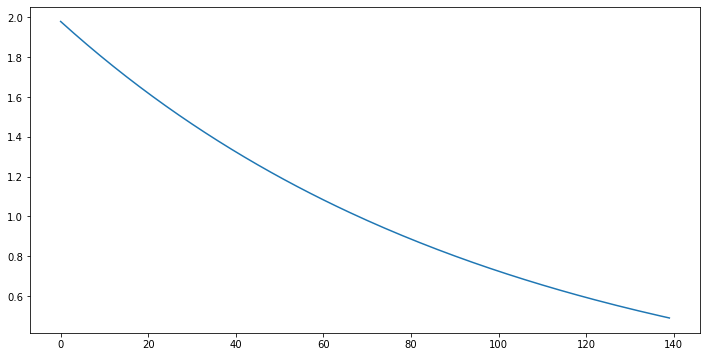

In [29]:
clip = 0.2
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(model[..., ivs].detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-6e-5, vmax=6e-5,
           extent = (r[0], r[-1], t[-1], t[0]))
ax1.set_title('Estimated Model')
ax2.imshow(dmod[..., ivs].detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup[..., ivs].detach().numpy().max(), vmax=clip*pup[..., ivs].detach().numpy().max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax2.set_title('Modelled data')
ax3.imshow((dmod[..., ivs]-pup[..., ivs]).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup[..., ivs].detach().numpy().max(), vmax=clip*pup[..., ivs].detach().numpy().max(),
           extent = (r[0], r[-1], t[-1], t[0]))
ax3.set_title('Residual')
ax3.set_ylim(4, 0);

fig = plt.figure(figsize= (12,6))
plt.plot(lr);

## Comparison

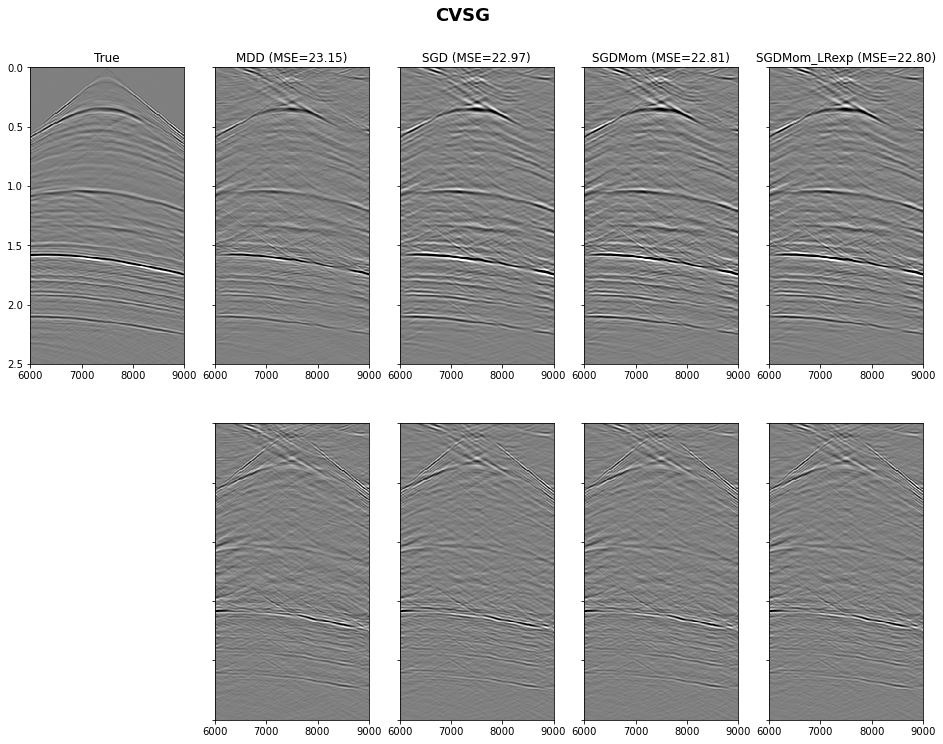

In [30]:
clip = 0.6

# remove negative times from MSE computation!
tpad = 500 
fig, axs = plt.subplots(2, len(mdict)+2, sharey=True, figsize=(16, 12))
fig.suptitle('CVSG', fontsize=18, fontweight='bold', y=.95)
axs[0][0].imshow(Rfilt[:nt, :, ivs]/np.abs(Rfilt[:nt-tpad, :, ivs]).max(), aspect='auto', interpolation='nearest', cmap='gray',
                 vmin=-clip, vmax=clip,
                 extent = (r[0], r[-1], t[-1], t[0]))
axs[0][0].axis('tight')
axs[0][0].set_title('True')
axs[0][1].imshow(Rinv[:nt, :, ivs]/np.abs(Rinv[:nt-tpad, :, ivs]).max(), aspect='auto', interpolation='nearest', cmap='gray',
                 vmin=-clip, vmax=clip,
                 extent = (r[0], r[-1], t[-1], t[0]))
axs[0][1].axis('tight')
axs[0][1].set_title('MDD (MSE=%.2f)' % np.linalg.norm(Rfilt[:nt-tpad, :, ivs]/np.abs(Rfilt[:nt-tpad, :, ivs]).max()-
                                                      Rinv[:nt-tpad, :, ivs]/np.abs(Rinv[:nt-tpad, :, ivs]).max()))

for iloss, loss in enumerate(mdict.keys()):
    axs[0][iloss+2].imshow(mdict[loss][:nt, :, ivs]/mdict[loss][:nt-tpad, :, ivs].max(), 
                           aspect='auto', interpolation='nearest', cmap='gray',
                           vmin=-clip, vmax=clip,
                           extent = (r[0], r[-1], t[-1], t[0]))
    axs[0][iloss+2].axis('tight')
    axs[0][iloss+2].set_title('%s (MSE=%.2f)' % 
                              (loss, np.linalg.norm(Rfilt[:nt-tpad, :, ivs]/np.abs(Rfilt[:nt-tpad, :, ivs]).max()-
                                                    mdict[loss][:nt-tpad, :, ivs]/np.abs(mdict[loss][:nt-tpad, :, ivs]).max())))
axs[0][-1].set_ylim(2.5, 0)

axs[1][0].axis('off')
axs[1][1].imshow(Rfilt[:nt, :, ivs]/np.abs(Rfilt[:nt, :, ivs]).max()-Rinv[:nt, :, ivs]/np.abs(Rinv[:nt, :, ivs]).max(), 
                 aspect='auto', interpolation='nearest', cmap='gray',
                 vmin=-clip, vmax=clip,
                 extent = (r[0], r[-1], t[-1], t[0]))
axs[1][1].axis('tight')

for iloss, loss in enumerate(mdict.keys()):
    axs[1][iloss+2].imshow(Rfilt[:nt, :, ivs]/np.abs(Rfilt[:nt-tpad, :, ivs]).max()-
                           mdict[loss][:nt, :, ivs]/np.abs(mdict[loss][:nt-tpad, :, ivs]).max(), 
                           aspect='auto', interpolation='nearest', cmap='gray',
                           vmin=-clip, vmax=clip,
                           extent = (r[0], r[-1], t[-1], t[0]))
    axs[1][iloss+2].axis('tight')
axs[1][-1].set_ylim(2.5, 0)
plt.savefig('Figs/MDDSaltMultiPrec_solutions_batch%d_nepoch%d' % (batch_size, nepochs));

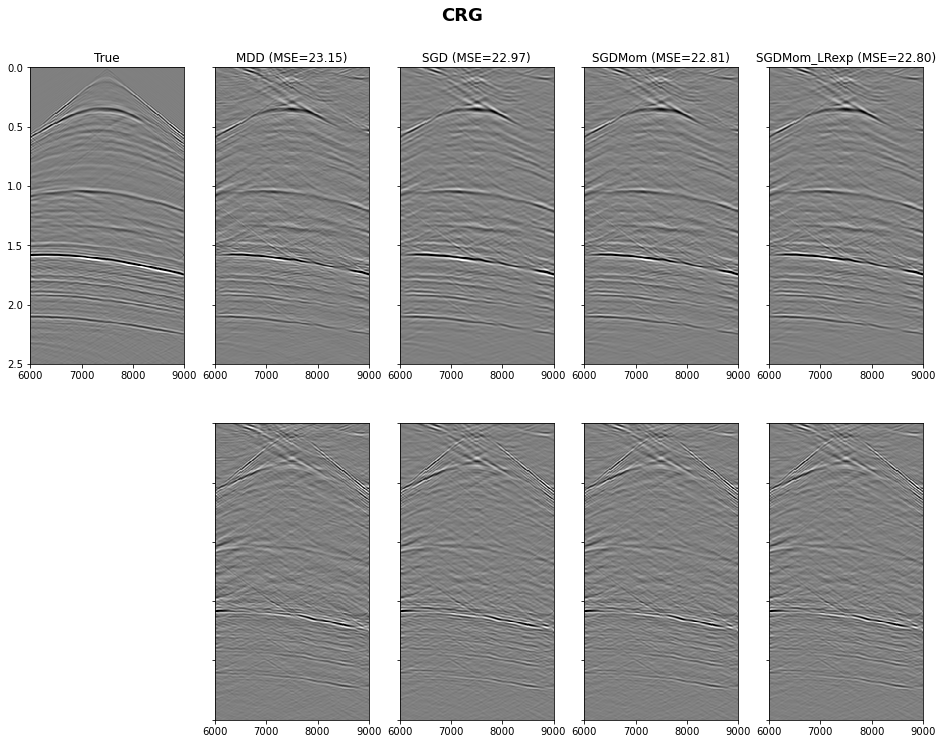

In [31]:
# remove negative times from MSE computation!
ir = nr//2

fig, axs = plt.subplots(2, len(mdict)+2, sharey=True, figsize=(16, 12))
fig.suptitle('CRG', fontsize=18, fontweight='bold', y=.95)
axs[0][0].imshow(Rfilt[:nt, ir]/np.abs(Rfilt[:nt-tpad, ir]).max(), aspect='auto', interpolation='nearest', cmap='gray',
                 vmin=-clip, vmax=clip,
                 extent = (r[0], r[-1], t[-1], t[0]))
axs[0][0].axis('tight')
axs[0][0].set_title('True')
axs[0][1].imshow(Rinv[:nt, ir]/np.abs(Rinv[:nt-tpad, ir]).max(), aspect='auto', interpolation='nearest', cmap='gray',
                 vmin=-clip, vmax=clip,
                 extent = (r[0], r[-1], t[-1], t[0]))
axs[0][1].axis('tight')
axs[0][1].set_title('MDD (MSE=%.2f)' % np.linalg.norm(Rfilt[:nt-tpad, ir]/np.abs(Rfilt[:nt-tpad, ir]).max()-Rinv[:nt-tpad, ir]/np.abs(Rinv[:nt-tpad, ir]).max()))

for iloss, loss in enumerate(mdict.keys()):
    axs[0][iloss+2].imshow(mdict[loss][:nt, ir]/np.abs(mdict[loss][:nt-tpad, ir]).max(), 
                           aspect='auto', interpolation='nearest', cmap='gray',
                           vmin=-clip, vmax=clip,
                           extent = (r[0], r[-1], t[-1], t[0]))
    axs[0][iloss+2].axis('tight')
    axs[0][iloss+2].set_title('%s (MSE=%.2f)' % 
                              (loss, np.linalg.norm(Rfilt[:nt-tpad, ir]/np.abs(Rfilt[:nt-tpad, ir]).max()-
                                                    mdict[loss][:nt-tpad, ir]/np.abs(mdict[loss][:nt-tpad, ir]).max())))
axs[0][-1].set_ylim(2.5, 0)

axs[1][0].axis('off')
axs[1][1].imshow(Rfilt[:nt, ir]/np.abs(Rfilt[:nt-tpad, ir]).max()-Rinv[:nt, ir]/np.abs(Rinv[:nt-tpad, ir]).max(), 
                 aspect='auto', interpolation='nearest', cmap='gray',
                 vmin=-clip, vmax=clip,
                 extent = (r[0], r[-1], t[-1], t[0]))
axs[1][1].axis('tight')

for iloss, loss in enumerate(mdict.keys()):
    axs[1][iloss+2].imshow(Rfilt[:nt, ir]/np.abs(Rfilt[:nt-tpad, ir]).max()-mdict[loss][:nt, ir]/np.abs(mdict[loss][:nt-tpad, ir]).max(), 
                           aspect='auto', interpolation='nearest', cmap='gray',
                           vmin=-clip, vmax=clip,
                           extent = (r[0], r[-1], t[-1], t[0]))
    axs[1][iloss+2].axis('tight')
axs[1][-1].set_ylim(2.5, 0)
plt.savefig('Figs/MDDSaltMultiPrec_solutions1_batch%d_nepoch%d_ir%d' % (batch_size, nepochs, ir));

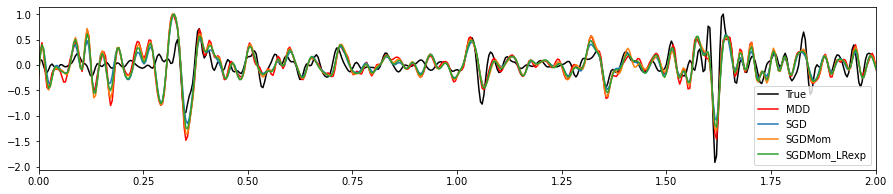

In [32]:
plt.figure(figsize=(15, 3))
plt.plot(t, Rfilt[:nt, ivs, nr//2] / Rfilt[:nt, ivs, nr//2].max(), 'k', label='True')
plt.plot(t, Rinv[:nt, ivs, nr//2] / Rinv[:nt, ivs, nr//2].max(), 'r', label='MDD')
for iloss, loss in enumerate(mdict.keys()):
    plt.plot(t, mdict[loss][:nt, ivs, nr//2]/mdict[loss][:nt, ivs, nr//2].max(), label=loss)
plt.legend()
plt.xlim(0, 2.);

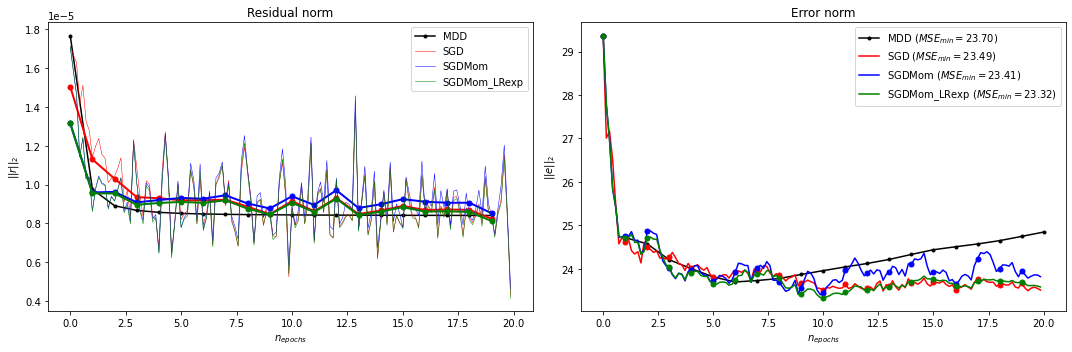

In [33]:
colors = ('r', 'b', 'g')

fig, axs = plt.subplots(1, 2, figsize= (15,5))
axs[0].plot(np.arange(nepochs), bench_resnorm[:nepochs], '.-k', label="MDD")
for loss, avg, color in zip(lossdict.keys(), avgdict.keys(), colors):
    axs[0].plot((np.arange(0, no_of_batches*nepochs, no_of_batches))/no_of_batches, avgdict[avg], 
                '.-%s' % color, ms=10, linewidth = 2)
    axs[0].plot(np.arange(len(lossdict[loss]))/no_of_batches , lossdict[loss], '%s' % color, label = loss, lw=0.5)
axs[0].set_xlabel(r'$n_{epochs}$')
axs[0].set_ylabel(r'$||r||_2$')
axs[0].set_title("Residual norm")
axs[0].legend()

axs[1].plot(np.arange(nepochs)+1, bench_enorm[:nepochs], '.-k', 
            label=r"MDD ($MSE_{min}=%.2f)$" % np.array(bench_enorm[:nepochs]).min())
for enorm, color in zip(enormdict.keys(), colors):
    axs[1].plot(np.arange(len(enormdict[enorm]))/no_of_batches, enormdict[enorm], 
                '%s' % color, ms=10, label=r"%s ($MSE_{min}=%.2f)$" % (enorm, np.array(enormdict[enorm]).min()))
    axs[1].plot((np.arange(len(enormdict[enorm]))/no_of_batches)[::no_of_batches], enormdict[enorm][::no_of_batches],
                '.%s' % color, ms=10, linewidth = 2)
axs[1].set_xlabel(r'$n_{epochs}$')
axs[1].set_ylabel(r'$||e||_2$')
axs[1].set_title("Error norm")
axs[1].legend()
fig.tight_layout()
plt.savefig('Figs/MDDSaltMultiPrec_residual_error_norms_batch%d_nepoch%d' % (batch_size, nepochs))

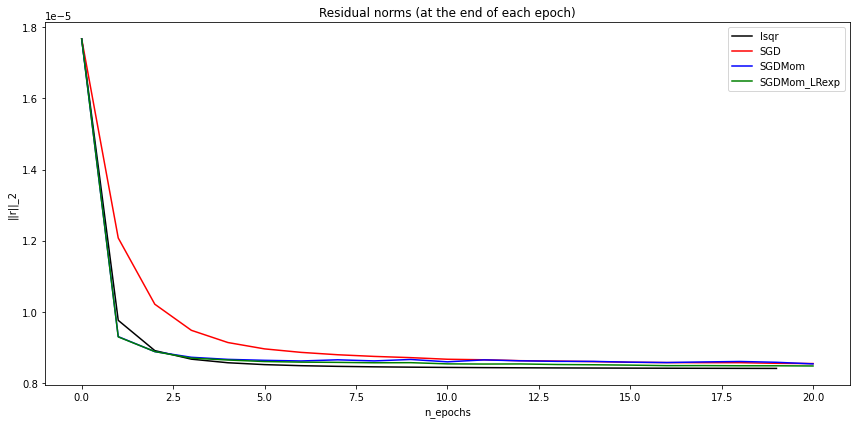

In [34]:
colors = ('r', 'b', 'g')

fig = plt.figure(figsize= (12,6))
plt.plot(np.arange(nepochs), bench_resnorm[:nepochs], 'k', label='lsqr')
for loss, color in zip(lossdict.keys(), colors):
    if loss != 'Page':
        plt.plot(np.arange(nepochs+1), lossepochdict[loss], color, label = str(loss).split()[0])
plt.xlabel('n_epochs')
plt.ylabel('||r||_2')
plt.title('Residual norms (at the end of each epoch)')
plt.legend()
plt.tight_layout()
plt.savefig('Figs/MDDSaltMultiPrec_finalresidual_batch%d_nepoch%d' % (batch_size, nepochs))

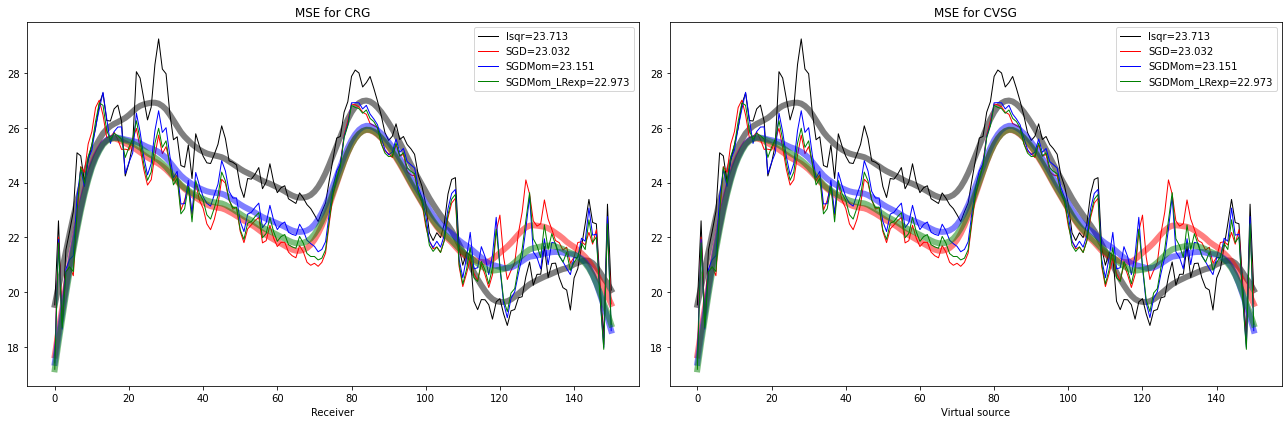

In [35]:
# All receivers/virtual sources
fig, axs = plt.subplots(1, 2, figsize= (18, 6))
nsmooth = 11
smooth = np.ones(nsmooth) / nsmooth

# CRG
erronorm = {loss:[] for loss in list(mdict.keys())}
erronorm['MDD'] = []
twin = 0
for ir in range(nr):
    erronorm['MDD'].append(np.linalg.norm(Rfilt[:ntpad-twin, ir]/np.abs(Rfilt[:ntpad-twin, ir]).max()-
                                          Rinv[:ntpad-twin, ir]/np.abs(Rinv[:ntpad-twin, ir]).max()))
    for iloss, loss in enumerate(mdict.keys()):
        erronorm[loss].append(np.linalg.norm(Rfilt[:ntpad-twin, ir]/np.abs(Rfilt[:ntpad-twin, ir]).max()-
                                             mdict[loss][:ntpad-twin, ir]/np.abs(mdict[loss][:ntpad-twin, ir]).max()))
axs[0].plot(erronorm['MDD'], 'k', lw=1, label='lsqr=%.3f' % np.mean(erronorm['MDD']))
axs[0].plot(filtfilt(smooth, 1, erronorm['MDD']), 'k', lw=6, alpha=0.5)
for loss, color in zip(mdict.keys(), colors):
    axs[0].plot(erronorm[loss], color, lw=1, label='%s=%.3f' % (loss, np.mean(erronorm[loss])))
    axs[0].plot(filtfilt(smooth, 1, erronorm[loss]), color, lw=6, alpha=0.5)
axs[0].legend()
axs[0].set_xlabel('Receiver')
axs[0].set_title('MSE for CRG')

# CVSG
erronorm = {loss:[] for loss in list(mdict.keys())}
erronorm['MDD'] = []
for ivs_ in range(nvs):
    erronorm['MDD'].append(np.linalg.norm(Rfilt[:ntpad-twin, :, ivs_]/np.abs(Rfilt[:ntpad-twin, :, ivs_]).max()-
                                          Rinv[:ntpad-twin, :, ivs_]/np.abs(Rinv[:ntpad-twin, :, ivs_]).max()))
    for iloss, loss in enumerate(mdict.keys()):
        erronorm[loss].append(np.linalg.norm(Rfilt[:ntpad-twin, :, ivs_]/np.abs(Rfilt[:ntpad-twin, :, ivs_]).max()-
                                             mdict[loss][:ntpad-twin, :, ivs_]/np.abs(mdict[loss][:ntpad-twin, :, ivs_]).max()))

axs[1].plot(erronorm['MDD'], 'k', lw=1, label='lsqr=%.3f' % np.mean(erronorm['MDD']))
axs[1].plot(filtfilt(smooth, 1, erronorm['MDD']), 'k', lw=6, alpha=0.5)
for loss, color in zip(mdict.keys(), colors):
    axs[1].plot(erronorm[loss], color, lw=1, label='%s=%.3f' % (loss, np.mean(erronorm[loss])))
    axs[1].plot(filtfilt(smooth, 1, erronorm[loss]), color, lw=6, alpha=0.5)
axs[1].legend()
axs[1].set_xlabel('Virtual source')
axs[1].set_title('MSE for CVSG')
fig.tight_layout()

fig.savefig('Figs/MDDSaltMultiPrec_CRGCVSGerror_batch%d_nepoch%d' % (batch_size, nepochs))

In [36]:
bench_enorm, erronorm['MDD'][75]

([24.719339003420732,
  24.575237447643424,
  24.208963762055404,
  24.006562297408404,
  23.814343629597467,
  23.69901665942051,
  23.73261569556053,
  23.77905102215772,
  23.872454323821778,
  23.960324106511916,
  24.045470124023524,
  24.125342783675656,
  24.21855638595413,
  24.332981684034138,
  24.440748740614364,
  24.508513924101432,
  24.5729655731789,
  24.649591368210658,
  24.74721198689167,
  24.84703571602181],
 24.847035716021814)

In [37]:
np.savez('Data/mdd_salt_multi_iter%d_batch%d_ivs%d' % (niter, batch_size, ivs), t=t,
         Radj=Radj[:nt, :, ivs], Rinv=Rinv[:nt, :, ivs], 
         Rsgd=mdict['SGD'][:nt, :, ivs], Rnsgd=mdict['SGDMom'][:nt, :, ivs], Rnsgd_lrexp=mdict['SGDMom_LRexp'][:nt, :, ivs], 
         resmdd=bench_resnorm[:nepochs], ressgd=lossdict['SGD'], resnsgd=lossdict['SGDMom'], resnsgd_lrexp=lossdict['SGDMom_LRexp'],
         avgressgd=avgdict['SGD'], avgresnsgd=avgdict['SGDMom'], avgresnsgd_lrexp=avgdict['SGDMom_LRexp'],
         errmdd=bench_enorm[:nepochs], errsgd=enormdict['SGD'], 
         errnsgd=enormdict['SGDMom'], errnsgd_lrexp=enormdict['SGDMom_LRexp'],
         errmddall=erronorm['MDD'], errsgdall=erronorm['SGD'], 
         errnsgdall=erronorm['SGDMom'], errnsgd_lrexpall=erronorm['SGDMom_LRexp'])

In [38]:
ivss = [20, 40, 90, 120]
for ivs1 in ivss:
    np.savez('Data/mdd_salt_multi_iter%d_batch%d_ivs%d' % (niter, batch_size, ivs1), t=t,
             Radj=Radj[:nt, :, ivs1], Rinv=Rinv[:nt, :, ivs1], 
             Rsgd=mdict['SGD'][:nt, :, ivs1], Rnsgd=mdict['SGDMom'][:nt, :, ivs1], 
             Rnsgd_lrexp=mdict['SGDMom_LRexp'][:nt, :, ivs1])